# Prévision des ventes d'une campagne pharmaceutique

### Chargement des principales librairies

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import itertools
import warnings                                  
warnings.filterwarnings('ignore')

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [75]:
#Paramètres de style
params = {'figure.figsize': (10, 5)}

# Mise à jour des paramètres globaux de matplotlib/pylab
pylab.rcParams.update(params)

## 1- Préparation et analyse préliminaire

### 1.1. Importation du jeu de données

In [76]:
sales_data=pd.read_excel(r"C:\Users\johan\Documents\MASTER ESA\Master 1\Projet_prévison\MP_Projet_202404.xlsx")
sales_data.head()

,Date,Monthly Sales
0,38899,3.526591
1,38930,3.180891
2,38961,3.252221
3,38991,3.611003
4,39022,3.565869


In [77]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           192 non-null    int64  
 1   Monthly Sales  192 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.1 KB


###### Mise au format "datetime" de la colonne "Date"

In [78]:
#Définir la date de référence
reference_date=pd.Timestamp('1900-01-01')

#On convertit la colonne date du jeu de données en nombre de jours qu'on rajoute à la date de référence
sales_data["Date"]=reference_date + pd.to_timedelta(sales_data["Date"]-2,unit="D")
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           192 non-null    datetime64[ns]
 1   Monthly Sales  192 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB


In [79]:
sales_data=sales_data.set_index("Date")
sales_data.head()

,Monthly Sales
Date,
2006-07-01,3.526591
2006-08-01,3.180891
2006-09-01,3.252221
2006-10-01,3.611003
2006-11-01,3.565869


In [80]:
# Copie du jeu de données 
sales=sales_data.copy()

### 1.2. Réprésentation graphique de la série

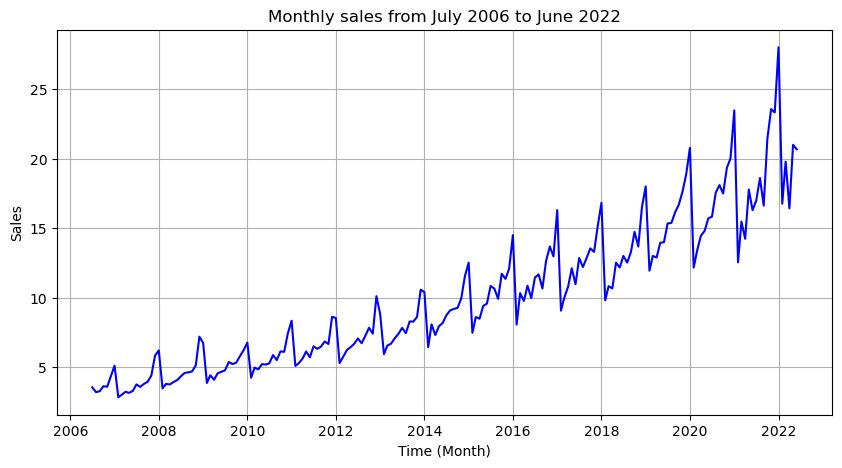

In [81]:
plt.plot(sales["Monthly Sales"],color="b")
plt.grid(True)
plt.xlabel("Time (Month)")
plt.ylabel("Sales")
plt.title("Monthly sales from July 2006 to June 2022")
plt.show()

La série des ventes présente une tendance générale à la hausse des ventes au fil des années. Cela 
indique une croissance continue de l'activité.

Des variations régulières et récurrentes sont observées sur le graphique. On peut y distinguer des pics et des creux qui se répètent chaque année, suggérant ainsi un effet saisonnier sur les ventes.

### 1.3. Statistiques descriptives

In [39]:
sales.isna().sum()
#Pas de valeurs manquantes

Monthly Sales    0
dtype: int64

In [40]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly Sales,192.0,9.914647,5.178802,2.81452,5.708018,8.662179,13.065699,28.038383


La
compagnie fait en moyenne 9.90 milles UM de ventes par mois.

### 1.4. La séparation train - test

La division train-test est une technique populaire pour partitionner un ensemble de données en 
deux parties : un ensemble d'apprentissage et un ensemble de test.
    
De cette division découle deux phases pour la construction du modèle prédictif.
    
<u> <b>Une phase d’entraînement<b/> </u> : On utilise l’échantillon d’apprentissage pour créer le modèle. Dans 
le cas d’un modèle paramétrique, par exemple, c’est dans cette phase que nous estimons les 
paramètres. En général, on entraîne plusieurs modèles ou plusieurs variantes d’un même modèle.

<u> <b>Une phase de validation</b> </u> : On utilise l’échantillon test (ou de validation) pour évaluer la 
performance du modèle sur des données qui n’ont pas servi à l’entraînement, de façon à éviter le 
surapprentissage. La performance du modèle peut se baser sur différents indicateurs. On choisit 
le modèle qui obtient la meilleure performance (l’EQM la plus faible par exemple) sur l’échantillon de 
validation

Nous divisons donc notre échantillon en 2 parties.
    
L’échantillon d’apprentissage qui sera constitué de 70% des observations, et l’échantillon de test des observations restantes.

L'échantillonage ne sera pas aléatoire afin de ne pas perdre la structure de dépendance présente dans les données.

In [82]:
# Calcul de la taille des deux échantillons
percent_70 = int(0.7 * len(sales))
percent_30 = len(sales) - percent_70

# Division du jeu de données en deux parties
train = sales.head(percent_70)
test = sales.tail(percent_30)

# Affichage des tailles des deux nouveaux échantillons
print("train(70%) :", len(train),"observations")
print("test(30%) :", len(test),"observations")

train(70%) : 134 observations
test(30%) : 58 observations


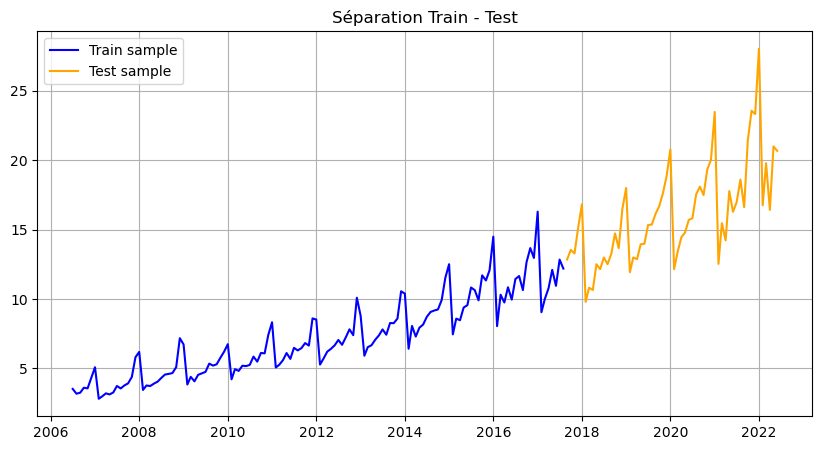

In [83]:
plt.plot(train, color="blue",label="Train sample")
plt.plot(test, color="orange",label="Test sample")
plt.title("Séparation Train - Test")
plt.grid()
plt.legend()

## 2. Analyses sur l'échantillon d'apprentissage

### 2.1. La décomposition tendance-cycle

L’analyse des séries temporelles repose le plus souvent sur une décomposition tendance 
saisonnalité et composante résiduelle de la série.

Toutefois, cette décomposition, si elle est très utilisée en pratique, ne repose pas sur une 
construction théorique unique.

<b>- La tendance</b> : Elle traduit l’évolution à long terme du phénomène. On parle aussi de mouvement 
conjoncturel ou mouvement extra-saisonnier.

<b>- La saisonnalité</b> : Elle correspond à des fluctuations périodiques qui se reproduisent à intervalle 
de temps régulier.

<b>- La composante résiduelle</b> : Elle rassemble tout ce que les autres composantes n’ont pu expliquer 
du phénomène observé. Elle contient donc de nombreuses fluctuations, en particulier 
accidentelles, dont le caractère est imprévisible (catastrophes naturelles, guerres, grèves...).

Dans les lignes qui suivront, nous nous attelerons à montrer la présence de saisonnalité en utilisant différentes méthodes.

### 2.2. Détection visuelle de la saisonalité

L’étude de la saisonnalité est un préalable au traitement d’une série chronologique. En effet, lorsque cette composante existe, il convient de l’isoler afin de pouvoir analyser les autres caractéristiques. Une désaisonnalisation systématique, sans tester l’existence de cette composante, peut créer un « bruit » parasite nuisible à l’analyse de la chronique et donc dégrader la qualité de la prévision.

Un box-plot peut aider à détecter la saisonnalité dans une série temporelle en comparant les 
distributions des données sur différentes périodes récurrentes, comme les mois ou les trimestres. 

Si la série temporelle présente une saisonnalité, les box-plots de ces périodes récurrentes 
montreront des différences systématiques dans leurs distributions.

In [84]:
train['year'] = train.index.year
train['month'] = train.index.month

Text(0.5, 1.0, 'Box-plots des ventes mensuels')

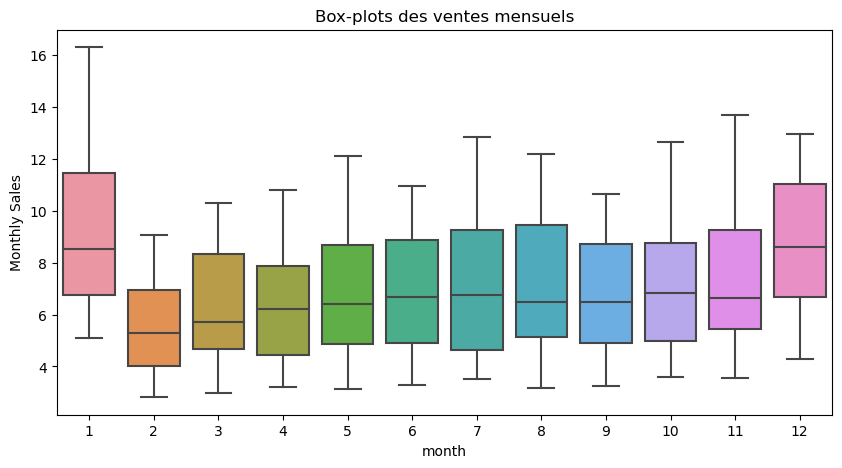

In [85]:
sns.boxplot(x="month", y = "Monthly Sales", data=train)
plt.title("Box-plots des ventes mensuels")

Le box-plot indique une présence marquée de saisonnalité avec des ventes nettement plus élevées 
et variables en janvier et en décembre, contrastant avec des mois plus stables et moins variables.

### 2.3. Modèles de décomposition

#### 2.3.1. Les types de modèles de décomposition

Il en existe essentiellement trois grands types : 
    
<b>Le schéma additif</b> : Il s’agit du modèle classique de décomposition. La chronique $X_{t}$ est la somme 
de la tendance $T_{t}$, de la saisonnalité $S_{t}$ et de l’erreur $E_{t}$.

On a:

\begin{equation}
X_t = T_t + S_t + E_t
\end{equation}

<b>Le schéma multiplicatif (mixte)</b> : dans lequel la composante saisonnière est liée à l'extra-saisonnier.

\begin{equation}
X_t = T_t * S_t + E_t
\end{equation}

<b>Le schéma multiplicatif complet</b> : présentant une interaction entre les trois composantes.

\begin{equation}
X_t = T_t * S_t * E_t
\end{equation}

#### 2.3.2. Choix du modèle de décomposition

 * <b> La Procédure de la bande</b>
 
Le « test de la bande » consiste à partir de l'examen visuel du graphique de l'évolution de la série 
brute à relier, par une ligne brisée, toutes les valeurs « hautes » et toutes les valeurs « basses » de 
la chronique.

Si les deux lignes sont parallèles, la décomposition de la chronique peut se faire 
selon un schéma additif ; dans le cas contraire, le schéma multiplicatif semble plus adapté.


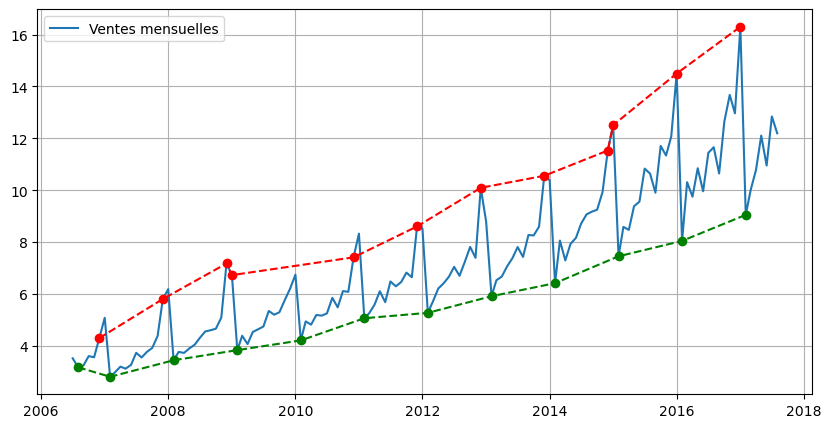

In [86]:
# Les pics (valeurs maximales) et les creux (valeurs minimales) pour chaque année
pics = train.groupby(train.index.year)['Monthly Sales'].idxmax()
creux = train.groupby(train.index.year)['Monthly Sales'].idxmin()

# Une liste pour stocker les indices de tous les pics et tous les creux
indices_pics = []
indices_creux = []

# les indices de tous les pics et tous les creux à la liste respective
for idx in pics:
    indices_pics.append(idx)
for idx in creux:
    indices_creux.append(idx)

#les valeurs correspondant aux pics et aux creux
valeurs_pics = train.loc[indices_pics, 'Monthly Sales']
valeurs_creux = train.loc[indices_creux, 'Monthly Sales']

#la série temporelle montrant l'évolution des ventes sur toute la période
plt.plot(train.index, train['Monthly Sales'], label='Ventes mensuelles')

#les droites reliant tous les pics et tous les creux
plt.plot(indices_pics, valeurs_pics, 'ro--')
plt.plot(indices_creux, valeurs_creux, 'go--')
plt.grid()

plt.legend()
plt.show()

Les deux lignes ne sont pas parallèles, le schéma multplicatif semble donc le plus adapté.

* <b> La méthode du profil </b>

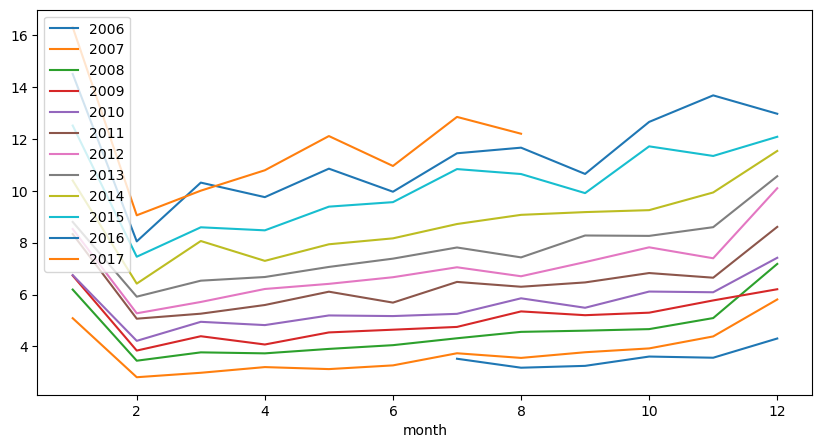

In [87]:
T_train = train.pivot(index = 'month', columns = 'year', values = 'Monthly Sales')

T_train.plot()
plt.legend(loc='upper left')

### 3. Choix du modèle de prévision

Il existe une grande variété de modèles permettant la prévision de série temporelles.

On distingue parmi elles deux grandes méthodes :
    
    - Les lissages exponentiels
    - Les modèles de types ARIMA


#### 3.1. Les lissages exponentiels

Les techniques de lissages exponentiels ont été introduits par Holt en 1957 mais surtout par Brown 
en 1962. Elles consistent à prévoir l’évolution d’une série par extrapolation.

Le lissage regroupe l’ensemble des techniques empiriques qui ont pour caractéristiques 
communes d’accorder un poids plus important aux valeurs récentes de la chronique.

Nous pouvons citer : 

    - Le lissage exponentiel simple
    - Le lissage exponentiel double
    - Lissage exponentiel double amorti de Gardber & McKenzie
    - Le lissage exponentiel triple de Holt-Winters.

Les trois premières méthodes sont inefficaces pour des séries temporelles avec des structures 
complexes comme la saisonnalité car elles n’intègrent pas dans leur spécification, des paramètres 
permettant de prendre en compte les composantes saisonnières des séries.
De plus, leurs performances sont assez médiocres pour les prévisions à long terme.

Pour la suite, nous focalisons donc sur la méthode de Holt-Winters. Elle est basée sur trois 
équations de lissage : une pour le niveau de la série, une pour la tendance et une pour la 
saisonnalité.

Il existe deux variantes de cette méthode qui diffèrent par la nature de la composante saisonnière. 
La méthode additive est préférable lorsque les variations saisonnières sont à peu près constantes 
tout au long de la série, tandis que la méthode multiplicative est préférable lorsque les variations 
saisonnières changent proportionnellement au niveau de la série.
Le modèle de décomposition de la série de ventes étudiée est multiplicatif. La méthode de Holt-Winters semble donc la plus adaptée aux données.

Nous présentons donc la méthode de lissage multiplicative de Holt-Winters ainsi que les résultats 
obtenus pour notre échantillon test.

* <b> Prévision avec le lissage exponentiel de Holt-Winters </b>

Sous python, la prévision se fait en utilisant la fonction ExponentialSmoothing du module 
statsmodels.

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES

model_HoltWinters = ES(endog = train['Monthly Sales'], trend="mul", seasonal = "mul", seasonal_periods = 12).fit()
HW_M_pred = model_HoltWinters.forecast(steps =(len(test))) 
HW_M_pred.tail(10)

2021-09-01    18.300042
2021-10-01    21.673211
2021-11-01    23.009831
2021-12-01    22.231300
2022-01-01    27.697810
2022-02-01    15.399832
2022-03-01    17.467163
2022-04-01    18.507923
2022-05-01    20.709107
2022-06-01    18.827726
Freq: MS, dtype: float64

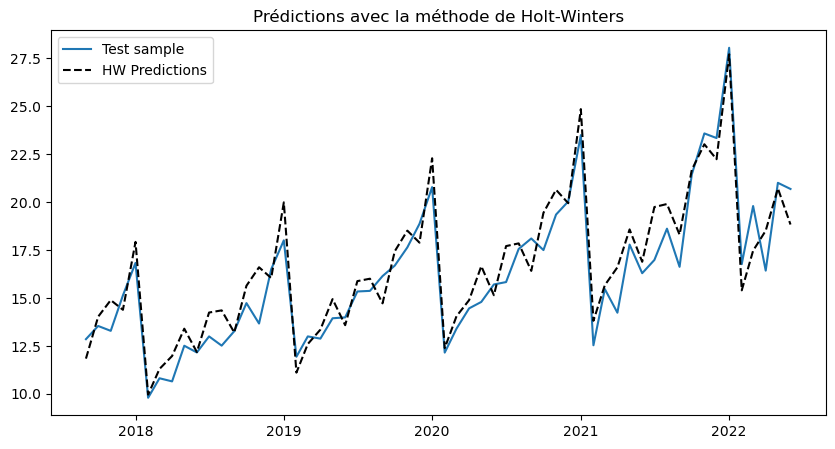

In [89]:
#Représentation de l'échantillon test vs la prédiction obtenue
plt.plot(test, label = "Test sample")
plt.plot(HW_M_pred, "k--", label = "HW Predictions")
plt.title("Prédictions avec la méthode de Holt-Winters")
plt.legend()

On peut constater que l’algorithme de Holt-Winters ajuste assez bien les données de l’échantillon 
de validation.

* <b> Mesure de la performance des prévisions </b>

Pour évaluer la performance du modèle, il est indispensable de calculer quelques mesures de 
performances. 

Nous nous limitons ici à trois mesures : la Mean Square Error (MSE), la Mean 
Absolute Percentage Error (MAPE) et la Mean Absolute Error (MAE).

In [90]:
from sklearn.metrics import mean_squared_error

# Calcul de la MSE
mse = mean_squared_error(test,HW_M_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.5802192351598994


In [91]:
from sklearn.metrics import mean_absolute_percentage_error

# Calcul de la MAPE
mape = mean_absolute_percentage_error(test,HW_M_pred)
print(f'Mean Absolute Percentage Error: {mape * 100:.2f}%')

Mean Absolute Percentage Error: 6.61%


In [92]:
from sklearn.metrics import mean_absolute_error

# Calcul de la MAE
mae = mean_absolute_error(test,HW_M_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1.0418555304613775


Les mesures sont assez faibles témoignant de la qualité de la prévision. Pour ne pas se limiter à 
ce modèle, les prévisions ont également réalisées sur la base d’un modèle SARIMA et de 
l’algorithme Prophet de Facebook.

Le modèle retenu est celui qui minimise les critères précédemment cités.

<b> 3.2. Prévision avec le modèle SARIMA </b>

Les modèles SARIMA, ou Seasonal Autoregressive Integrated Moving Average, sont une 
extension des modèles ARIMA (Autoregressive Integrated Moving Average) qui sont 
spécialement conçus pour modéliser et prédire des séries temporelles qui présentent des 
comportements saisonniers.

Les modèles SARIMA sont très utilisés dans les analyses temporelles 
où les données montrent non seulement des tendances et/ou des cycles mais aussi des variations 
saisonnières claires, comme dans le cas de ventes mensuelles, de températures journalières, ou 
d'autres indicateurs économiques et environnementaux.


Un modèle SARIMA est généralement noté comme SARIMA(p, d, q)(P, D, Q)[s], où <b>(p, d, q)</b> sont les paramètres non saisonniers :

p : L'ordre des termes autorégressifs (AR). Il s'agit du nombre de dépendances retardées incluses 
dans le modèle.

d : Le degré de différenciation. Cela indique combien de fois les données doivent être 
différenciées pour rendre la série stationnaire.

q : L'ordre des termes de moyenne mobile (MA). Il s'agit du nombre de termes de moyenne mobile 
dans le modèle.

<b>(P, D, Q)[s]</b> sont les paramètres saisonniers :

P : L'ordre des termes autorégressifs saisonniers.

D : Le degré de différenciation saisonnière. Il est similaire à d mais appliqué aux composantes 
saisonnières de la série.

Q : L'ordre des termes de moyenne mobile saisonniers.

S : Le nombre de périodes dans chaque saison. Par exemple, s serait 12 pour des données 
mensuelles avec une saisonnalité annuelle, ou 4 pour des données trimestrielles.

* <b> Analyse de la stationnarité de la série </b>

La stationnarité d'une série est une exigence préalable pour l'analyse avec de nombreux modèles de séries temporelles, y compris 
les SARIMA. 

Pour ce faire, nous avons utilisé le test de Dickey-Fuller augmenté pour tester la présence d'une racine unitaire.

In [93]:
from statsmodels.tsa.stattools import adfuller

#Test de dickey-fuller
result = adfuller(train['Monthly Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 4.860181779473749
p-value: 1.0
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580


Pour un seuil nominal de 5%, la statistique de test (4.86) est supérieure à la valeur critique (-2.89).
On conclut que la série des ventes mensuelles n'est pas stationnaire à niveau.
Le test est repris sur la différence première de la série.

L'objectif principal de l'étude de la stationnarité dans ctte étude est la détermination de l'ordre d'intégration (d) de la série.

In [94]:
# Première différenciation
train['Differenced Sales'] = train['Monthly Sales'].diff().dropna()

#Test de Dickey-Fuller augmenté sur la série différenciée
result_diff = adfuller(train['Differenced Sales'].dropna())

print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.462060851213844
p-value: 0.009016617376345818
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


On constate la série différenciée est stationnaire (pour un seuil de 5%).

On conclut que ventes mensuelles de la compagnié sont I(1).

Après l'étude de la staionnarité, il convient de déterminer les autres paramètres (p,q) et (P,D,Q)
en passant par une analyse des ACF (Autocorrelation Function) et PACF (Partial Autocorrelation Function).

Ici, nous avons avons opté pour l'utilisation de la fonction auto_arima de la bibliothèque Python pmdarima. 

Cette méthode automatise la sélection des 
paramètres du modèle ARIMA en testant une plage de combinaisons différentes pour les termes 
AR, I et MA, ainsi que pour les composantes saisonnières

* <b> Identification du modèle SARIMA optimal</b>

Les résultats du test de Dickey-Fuller réalisé précédemment nous ont permis de fixer le paramètre d de la fonction auto_arima à 1.

In [95]:
import pmdarima as pm

model = pm.auto_arima(train['Monthly Sales'],test='adf', start_p=0, start_q=0, 
                    m=12, 
                   start_P=0, seasonal=True, 
                   d=1, trace=True, 
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# Affichage du résumé du modèle sélectionné
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=240.467, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=238.794, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=199.543, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=166.412, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=164.624, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=166.422, Time=0.30 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=168.242, Time=0.52 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=165.852, Time=0.10 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=165.909, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=197.556, Time=0.07 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=167.831, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=166.030, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 2.354 seconds
                                      SARIMAX Results                                  

Le modèle optimal est un SARIMA <b>(0, 1, 1)x(0, 1, 0)[12]</b>.

* <b> Estimation du modèle</b>

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(train["Monthly Sales"], order=(0, 1, 1), seasonal_order=(0, 1, 0, 12), enforce_stationarity= False, 
            enforce_invertibility=False)
model_fit = model.fit(disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Monthly Sales   No. Observations:                  134
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 -79.428
Date:                             Sat, 27 Jul 2024   AIC                            162.855
Time:                                     23:36:54   BIC                            168.413
Sample:                                 07-01-2006   HQIC                           165.112
                                      - 08-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8861      0.043    -20.407      0.000      -0.971      -0.801
sigma2         0.2212      0.021     10.482      0.000       0.180       0.263
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                16.42
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* <b> Diagnostic du modèle</b>

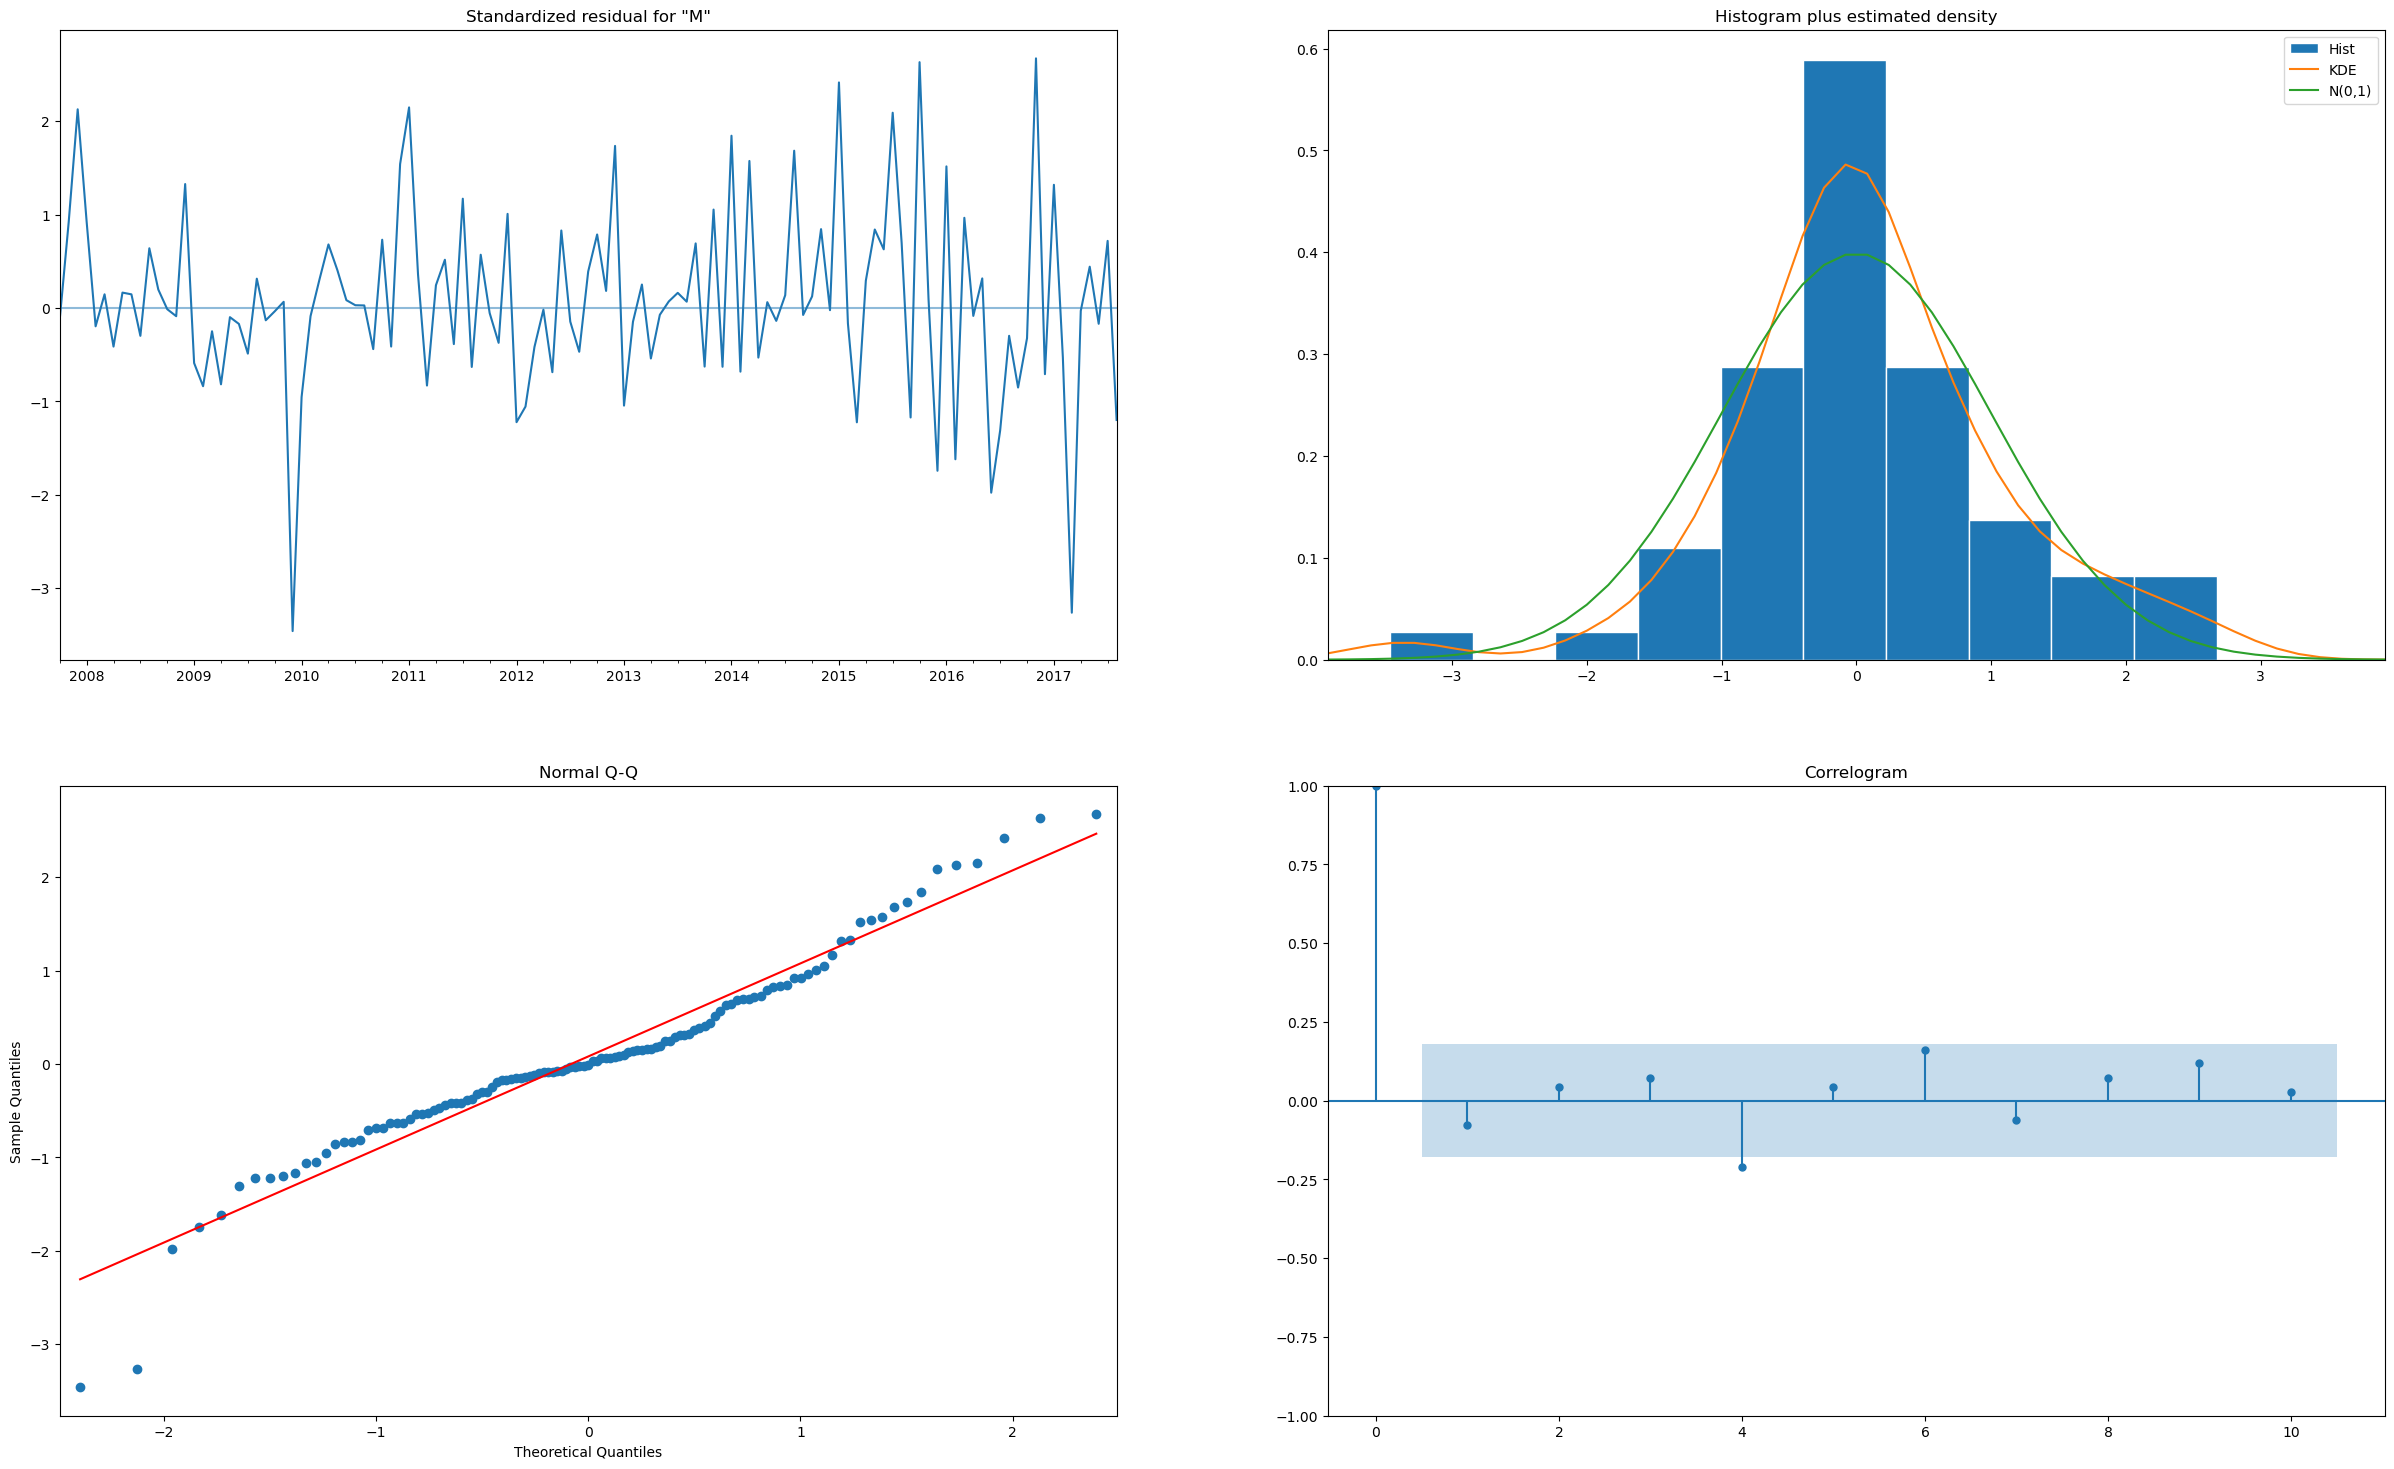

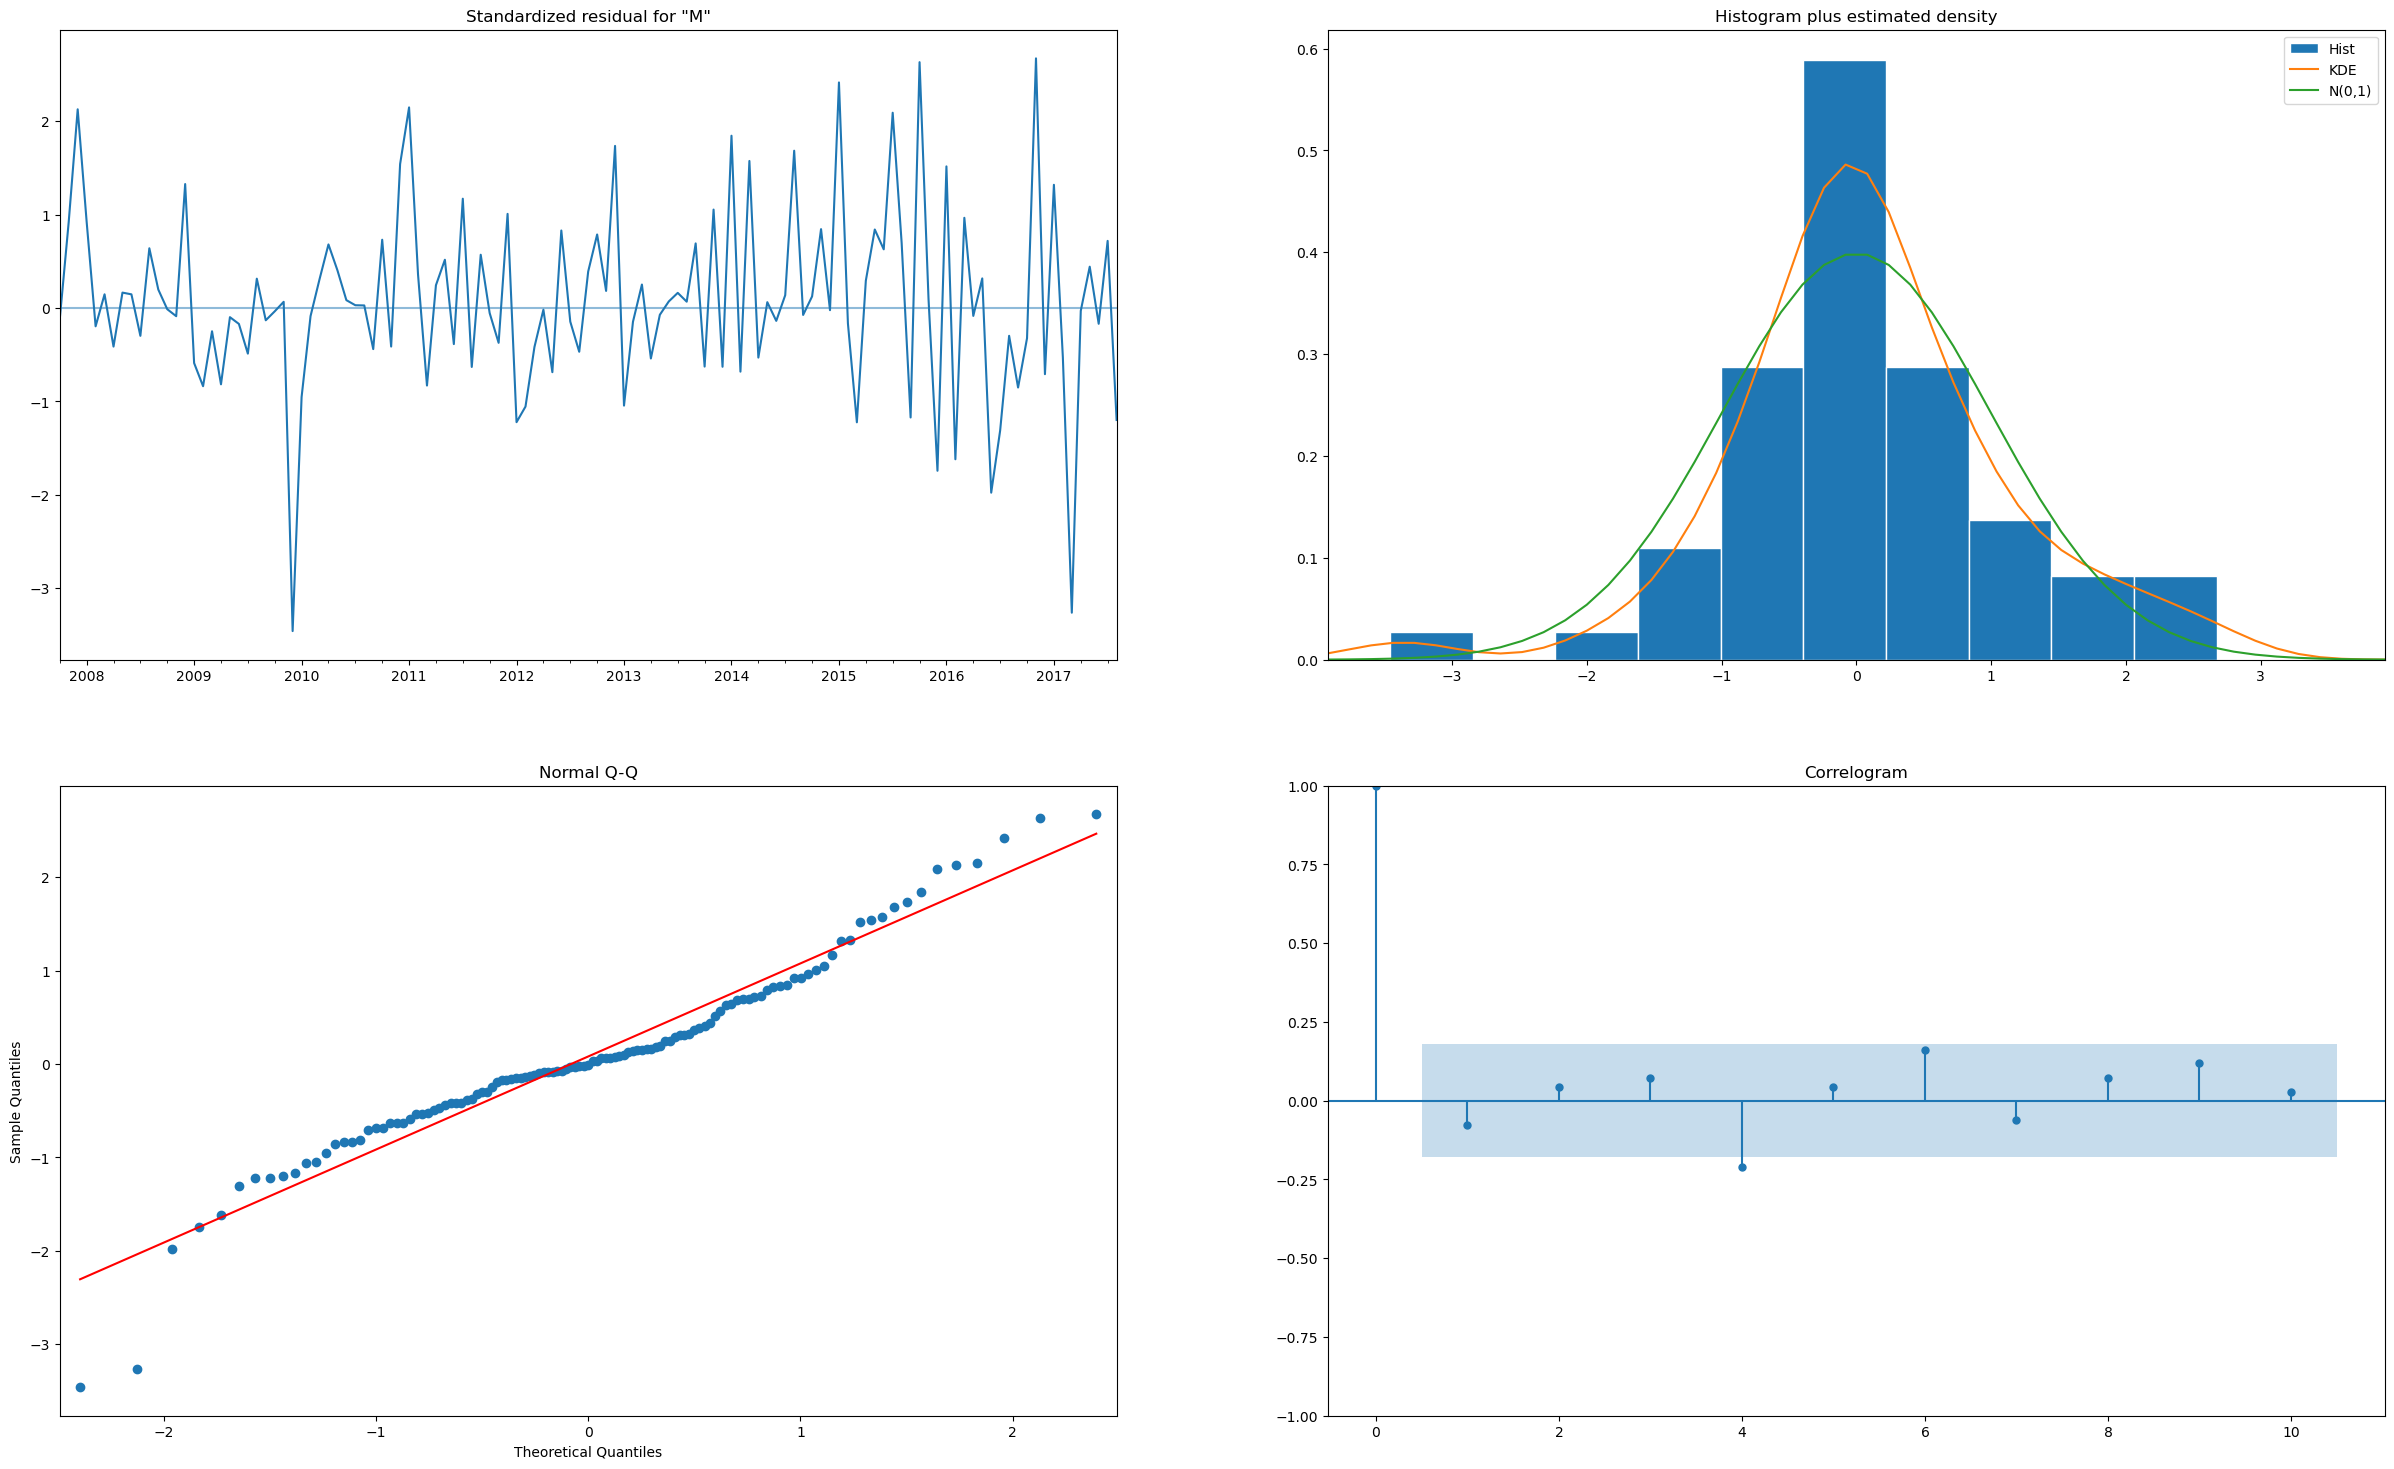

In [97]:
model_fit.plot_diagnostics(figsize= (30,18))

L’analyse du graphique des résidus standardisés et du corrélogramme permet de conclure à l'absence d'autocorrélation à divers décalages dans les résidus. Cela signifie que le modèle a réussi à capturer adéquatement l'information temporelle dans les données sans laisser de structures autocorrélées inexpliquées.

Cependant, le modèle souffre d’un problème d’hétéroscédasticité et de normalité des résidus. Dans un modèle à finalité de prédiction, les problèmes d'hétéroscédasticité et de normalité des résidus ne constituent pas nécessairement des obstacles critiques, car l'objectif principal est l'exactitude des prévisions plutôt que l'inférence statistique.

Le modèle SARIMA choisi a été ajusté sur l'échantillon d'apprentissage. Les prévisions ont été effectuées en utilisant la fonction get_forecast, qui permet de générer des prévisions à partir du modèle ajusté pour un nombre spécifié de périodes.

* <b>Calcul des prédictions et représentation graphique</b>

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

predictions = model_fit.forecast(steps=len(test))

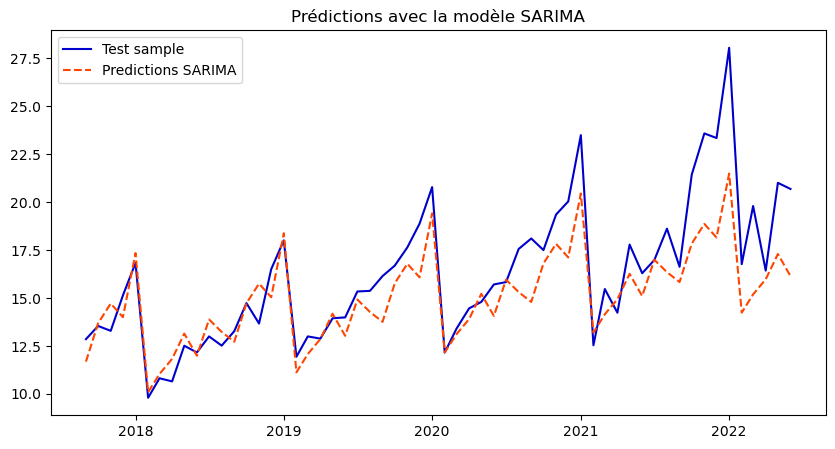

In [99]:
plt.plot(test, label="Test sample", color='mediumblue')
plt.plot(predictions, "k--",label='Predictions SARIMA', color='orangered')
plt.title("Prédictions avec la modèle SARIMA")
plt.legend()

* <b> Mesure de la performance des prévisions </b>

In [100]:
# MSE
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

# MAE
mae = mean_absolute_error(test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# MAPE
mape = mean_absolute_percentage_error(test, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')


Mean Squared Error: 4.397972609415334
Mean Absolute Error (MAE): 1.4976849484088413
Mean Absolute Percentage Error (MAPE): 8.30%


L'analyse des prévisions de ventes mensuelles générées par le modèle SARIMA, comparées aux 
données réelles de l'échantillon test sur la période de 2018-2022, révèle plusieurs points clés concernant la 
performance du modèle. 

Globalement, les prédictions du modèle s’ajustent bien aux données de 
l’échantillon de validation, ce qui indique que le modèle capture de manière efficace les tendances 
générales et les variations saisonnières observées dans les données de vente.

Cependant, certaines périodes, notamment vers la fin de 2021 et le début de 2022, montrent des 
divergences entre les valeurs prédites et les données réelles. Ces écarts peuvent refléter des limites 
dans le modèle actuel, probablement dues à des facteurs externes non pris en 
compte.

<b> 3.3. L'algorithme Prophet de Facebook </b>

Prophet est une bibliothèque open-source développée par Facebook pour la prévision de séries 
temporelles. Elle est particulièrement conçue pour traiter les séries temporelles avec des tendances 
non linéaires qui évoluent selon des saisons annuelles, hebdomadaires, des jours fériés et des 
événements irréguliers. Cette méthode possède les caractéristiques principales suivantes :
    
<b>Facilité d'utilisation</b> : Prophet est conçu pour être facilement utilisable par des non-experts en 
statistiques.

<b>Gestion des composantes saisonnières et des jours fériés</b> : La bibliothèque peut inclure 
automatiquement des effets saisonniers et des jours fériés spécifiques à différents domaines.

<b>Robustesse face aux valeurs manquantes et aux outliers</b> : Prophet est capable de gérer les 
valeurs manquantes et les valeurs aberrantes sans impact significatif sur les prévisions.

Une étape primordiale est la 
préparation des données de série temporelle dans un DataFrame pandas avec des colonnes 
nommées impérativement 'ds' pour les dates et 'y' pour les valeurs. 

Ensuite, le modèle Prophet est initialisé et ajusté aux données de l’échantillon d’apprentissage

In [101]:
# Format data for prophet model using ds and y
train = train.reset_index() \
    .rename(columns={'Date':'ds',
                   'Monthly Sales':'y'})
test = test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Monthly Sales':'y'})

Dans notre cas, nous spécifions la saisonnalité multiplicative (cf section 2.3). (créer un lien vers la scetion).

In [102]:
from prophet import Prophet

# Ajustement du modèle à l'échantillon d'apprentissage
MODELE_PROPHET = Prophet(seasonality_mode = "multiplicative")
MODELE_PROPHET.fit(train)

23:37:30 - cmdstanpy - INFO - Chain [1] start processing
23:37:30 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
# Création d'un dataframe pour recevoir les prévisions
horizon_pred = MODELE_PROPHET.make_future_dataframe(periods=len(test)+1, freq='M')

In [104]:
# Normalisation des dates au 1er du mois pour faciliter les interprétations
horizon_pred['ds'] = horizon_pred['ds'] - pd.offsets.MonthEnd(1) + pd.offsets.MonthBegin(1)

In [105]:
# Prévisions à partir de l'échantillon d'apprentissage
Pred_PROPHET = MODELE_PROPHET.predict(horizon_pred)
Pred_PROPHET.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2006-07-01,3.275344,2.816143,3.790880,3.275344,3.275344,0.005323,0.005323,0.005323,0.005323,0.005323,0.005323,0.0,0.0,0.0,3.292779
1,2006-08-01,3.328535,2.753630,3.758585,3.328535,3.328535,-0.012103,-0.012103,-0.012103,-0.012103,-0.012103,-0.012103,0.0,0.0,0.0,3.288249
2,2006-09-01,3.381726,2.831032,3.740676,3.381726,3.381726,-0.030350,-0.030350,-0.030350,-0.030350,-0.030350,-0.030350,0.0,0.0,0.0,3.279090
3,2006-10-01,3.433201,3.110504,4.052448,3.433201,3.433201,0.051272,0.051272,0.051272,0.051272,0.051272,0.051272,0.0,0.0,0.0,3.609229
4,2006-11-01,3.486392,3.249715,4.167233,3.486392,3.486392,0.062391,0.062391,0.062391,0.062391,0.062391,0.062391,0.0,0.0,0.0,3.703911


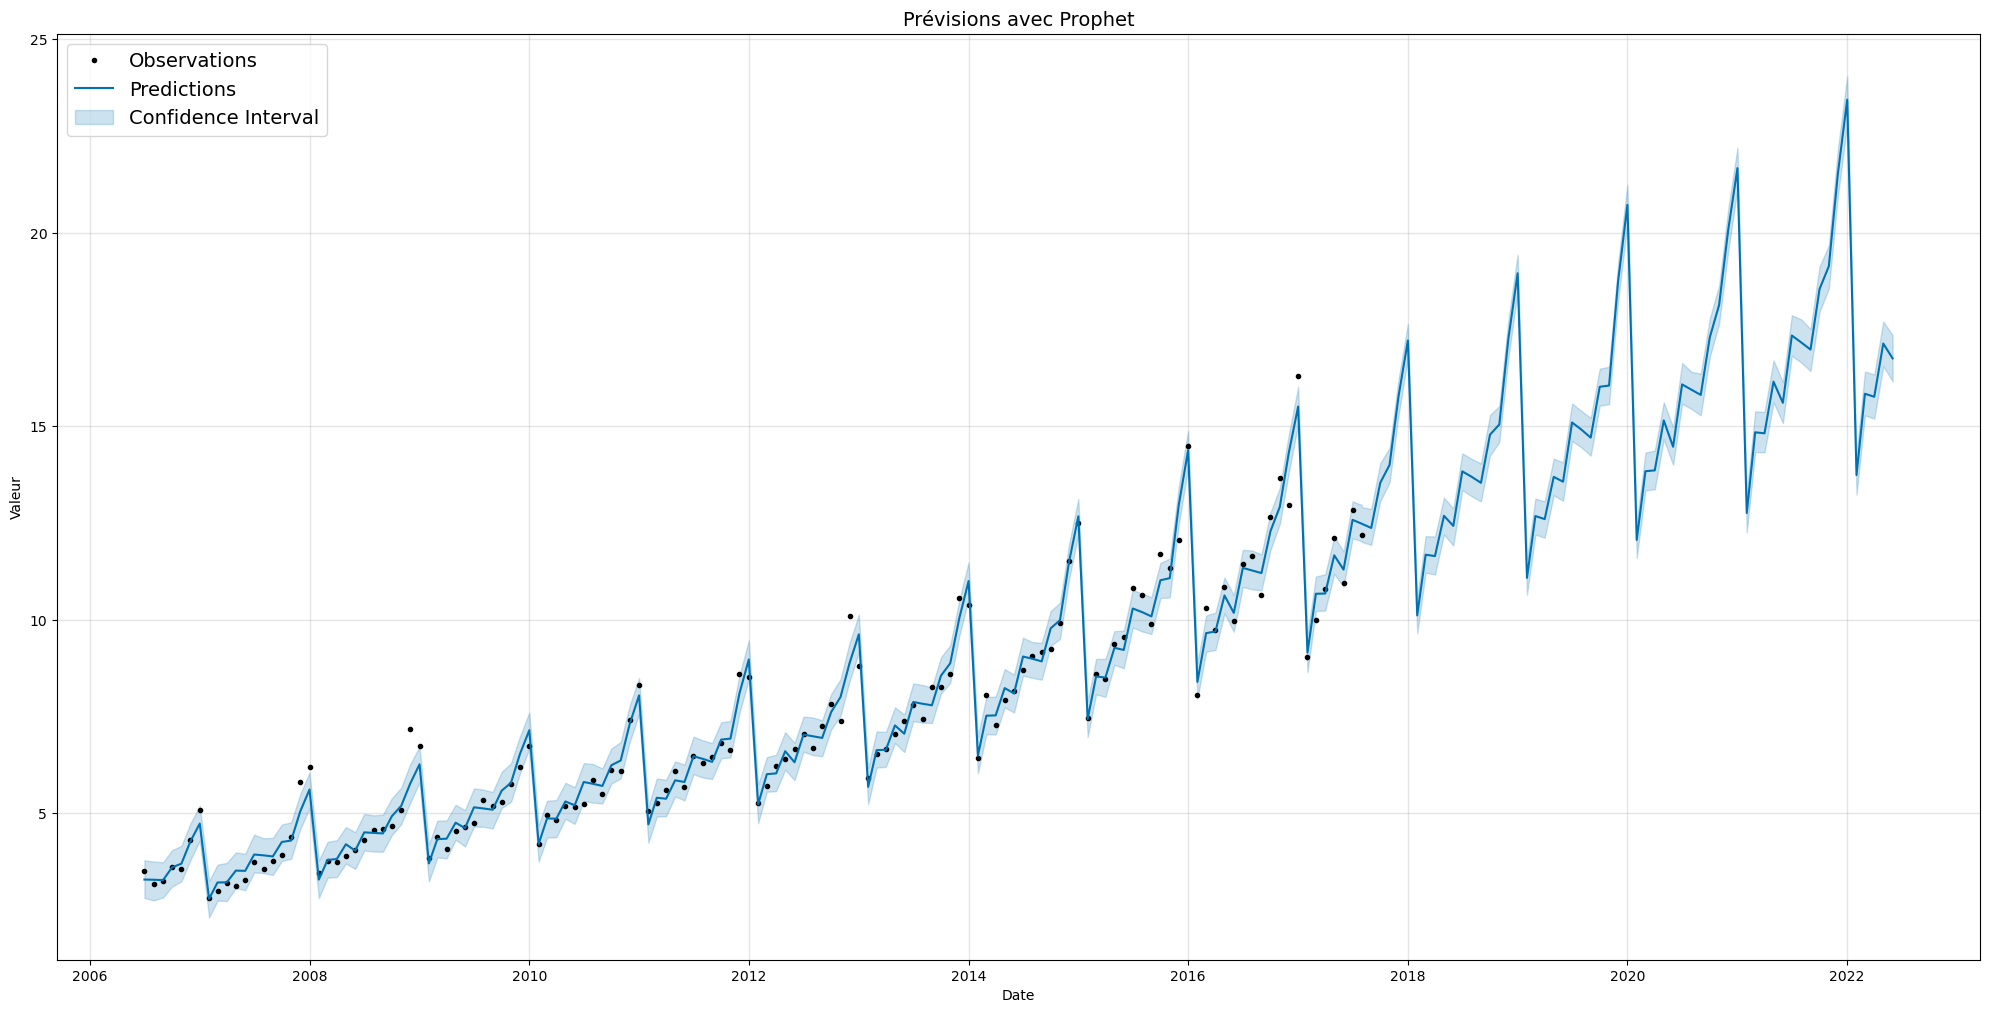

In [106]:
#Réprésentation de la prédiction obtenue
MODELE_PROPHET.plot(Pred_PROPHET, uncertainty = True,figsize= (20,10))

plt.legend(['Observations', 'Predictions', 'Confidence Interval'],fontsize=14)
plt.title('Prévisions avec Prophet',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()

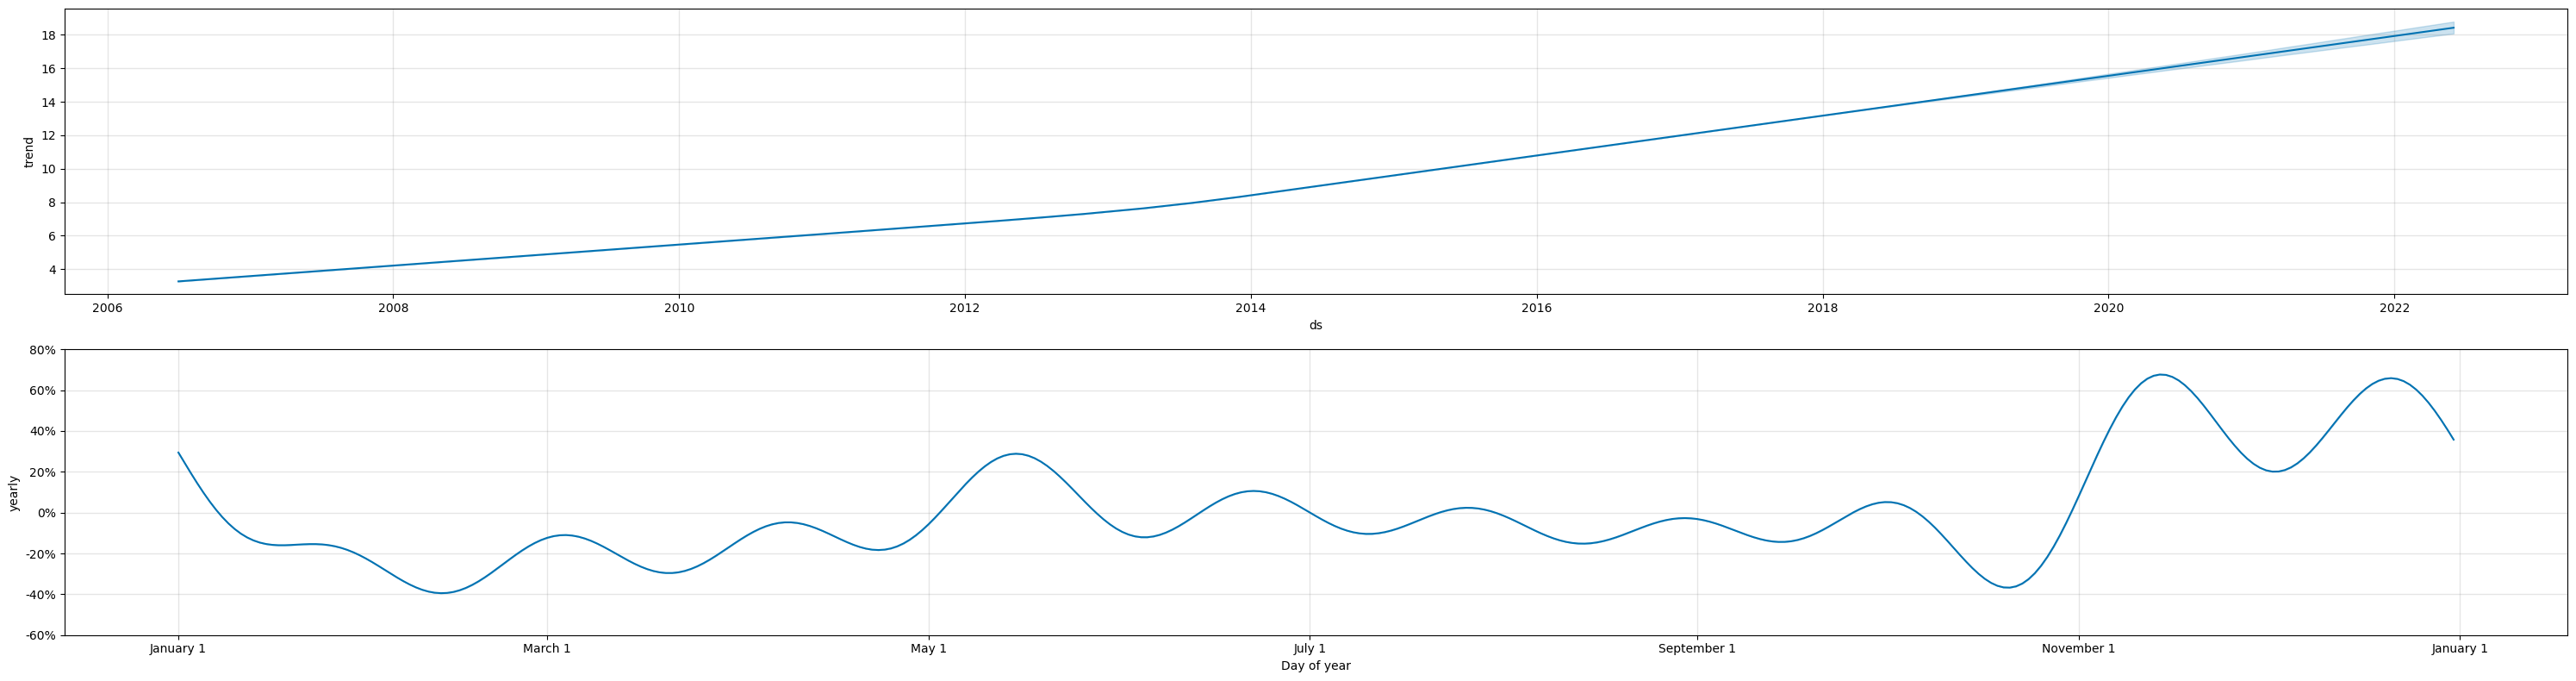

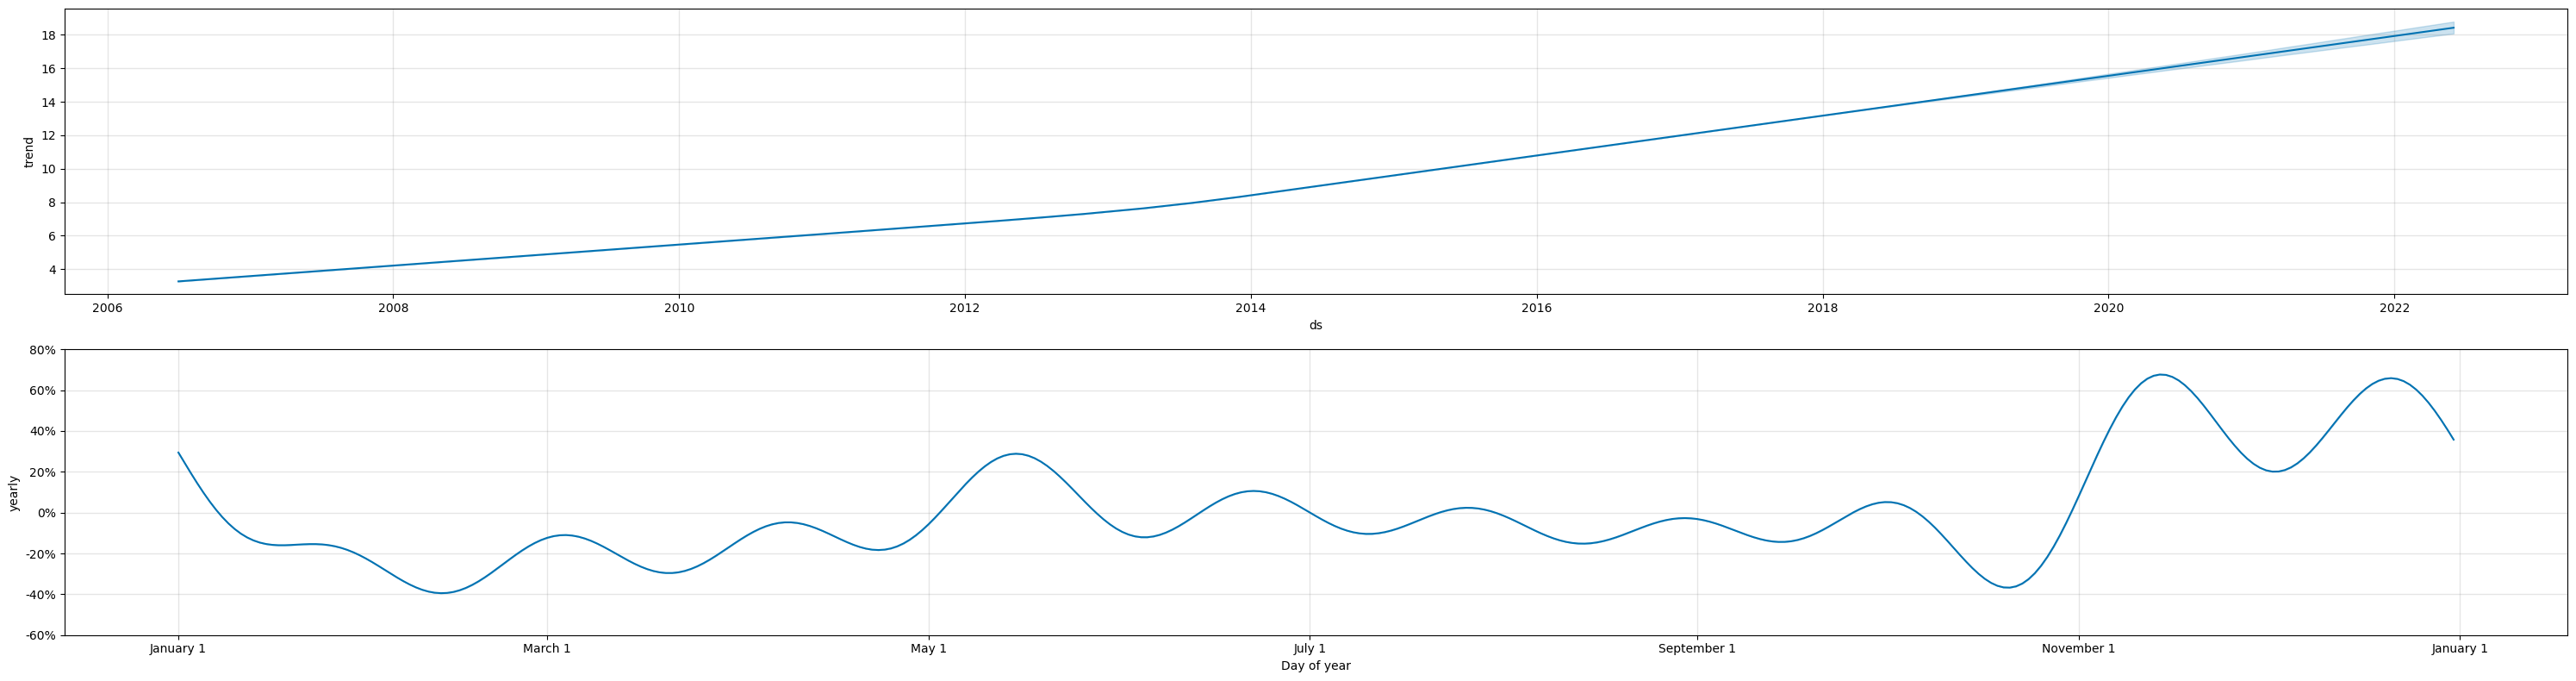

In [107]:
MODELE_PROPHET.plot_components(Pred_PROPHET, figsize= (30,8))

In [108]:
pred=Pred_PROPHET[['yhat']].tail(58)
pred=pred.reset_index()

In [109]:
pred=pred[['yhat']]
date=test['ds']
pred['ds']=date

In [110]:
# Concaténation des DataFrames test et pred
combined_df = pd.merge(test, pred[['ds', 'yhat']], on='ds', how='left')
combined_df=combined_df.set_index('ds')

* <b> Mesure de la performance des prévisions </b>

In [111]:
# MSE
mse=mean_squared_error(y_true=combined_df['y'],
                   y_pred=combined_df['yhat'])
# MAE
mae = mean_absolute_error(y_true=combined_df['y'], y_pred=combined_df['yhat'])

# MAPE
mape = mean_absolute_percentage_error(y_true=combined_df['y'], y_pred=combined_df['yhat'])

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 2.483814202444172
Mean Absolute Error (MAE): 1.0706297787856736
Mean Absolute Percentage Error (MAPE): 0.06%


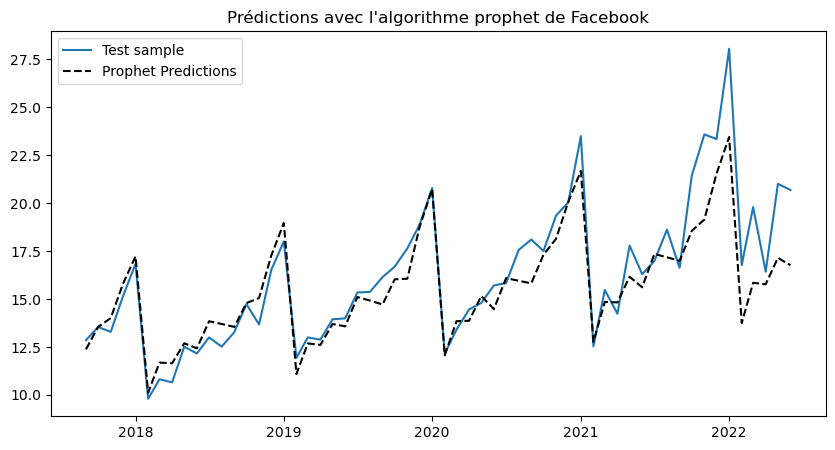

In [112]:
plt.plot(combined_df['y'], label = "Test sample")
plt.plot(combined_df['yhat'], "k--", label = "Prophet Predictions")
plt.title("Prédictions avec l'algorithme prophet de Facebook")
plt.legend()

On peut constater que l’algorithme Prophet ajuste assez bien aussi les données de 
l’échantillon de validation.

### 4. Méthode retenue pour la prédiction

Dans le cadre de notre étude visant à prédire les ventes d'une compagnie pharmaceutique, nous avons 
utilisé trois méthodes de prévision différentes : SARIMA, Holt-Winters et Prophet de Facebook. 

Après une analyse comparative basée sur la MSE, MAPE et MAE, la méthode Holt-Winters démontre une 
meilleure adéquation aux données, ce qui se traduit par une capacité supérieure à 
minimiser les erreurs de prévision sur notre ensemble de données. 

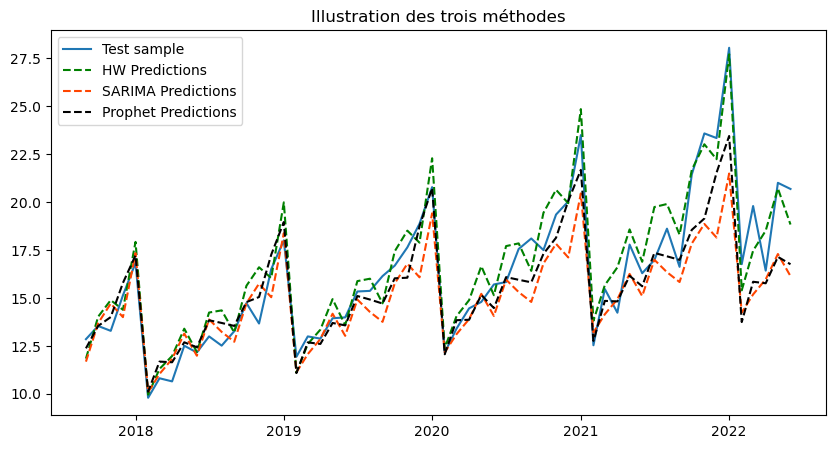

In [113]:
plt.plot(combined_df['y'], label = "Test sample")
plt.plot(HW_M_pred,"k--",label="HW Predictions",color="green")
plt.plot(predictions, "k--",label='SARIMA Predictions', color='orangered')
plt.plot(combined_df['yhat'], "k--", label = "Prophet Predictions")
plt.title("Illustration des trois méthodes")
plt.legend()

La prédiction des ventes pour la période juillet 2022 à juin 2023 basé sur la méthode de Holt-Winters se présente comme suit :

In [114]:
model_HoltWinters = ES(endog = sales['Monthly Sales'], trend="mul", seasonal = "mul", seasonal_periods = 12).fit()
HW_M_pred = model_HoltWinters.forecast(steps =12)

HW_M_pred

2022-07-01    21.491729
2022-08-01    22.070042
2022-09-01    22.042025
2022-10-01    24.088626
2022-11-01    25.176710
2022-12-01    27.361634
2023-01-01    30.940660
2023-02-01    18.181508
2023-03-01    21.004225
2023-04-01    20.113367
2023-05-01    23.084475
2023-06-01    22.633923
Freq: MS, dtype: float64

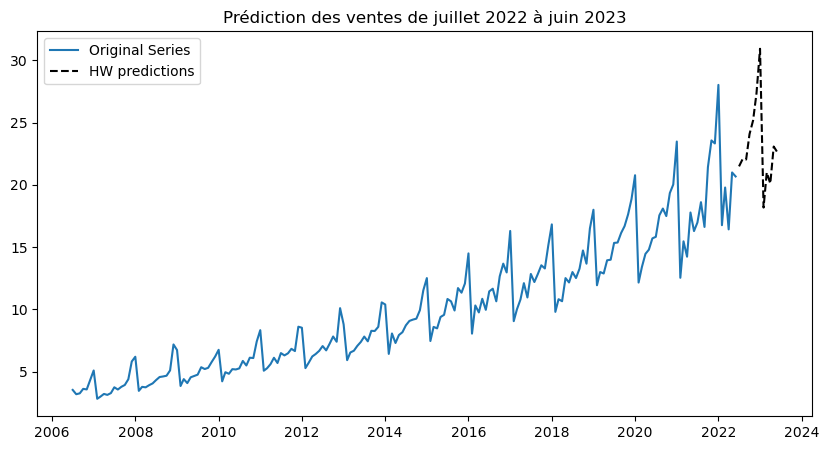

In [115]:
plt.plot(sales, label = "Original Series")
plt.plot(HW_M_pred, "k--", label = "HW predictions")
plt.title("Prédiction des ventes de juillet 2022 à juin 2023")
plt.legend()

### 5. Synthèse

L'évaluation de la performance des modèles de prévision révèle que la méthode de Holt-Winters surpasse les autres méthodes dans l'exactitude des prévisions. 
Le rapport conclut que, parmi les méthodes testées, la méthode Holt-Winters serait la plus appropriée pour la prévision des ventes futures de l'entreprise.